In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, classification_report

In [11]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
1    492
0    492
Name: count, dtype: int64


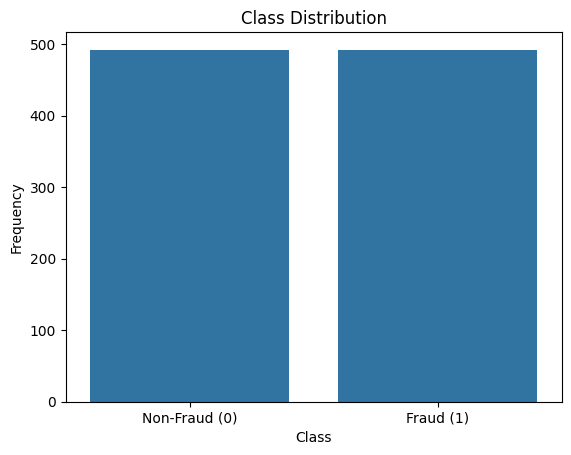

In [12]:

# Separate the majority and minority classes
data_majority = df[df['Class'] == 0]
data_minority = df[df['Class'] == 1]

# Undersample the majority class to match the minority class
data_majority_undersampled = resample(data_majority,
                                      replace=False,  # Sample without replacement
                                      n_samples=len(data_minority),  # Match the minority class size
                                      random_state=42)  # Ensure reproducibility

# Combine the undersampled majority class with the minority class
data = pd.concat([data_majority_undersampled, data_minority])

# Shuffle the dataset to ensure randomness
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution
print(data['Class'].value_counts())

# Visualize the class distribution
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()



In [13]:


# Scale 'Amount' and 'Time'
scaler = StandardScaler()
data['Amount_scaled'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time_scaled'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))

# Drop original 'Amount' and 'Time' columns
data = data.drop(['Amount', 'Time'], axis=1)

# Split into features and target
X = data.drop('Class', axis=1)
y = data['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [14]:


# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC if needed



In [15]:

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9257
F1-Score: 0.9236
Matthews Correlation Coefficient (MCC): 0.8526

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       148
           1       0.95      0.90      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296




Threshold | Accuracy | F1-Score | MCC
0.10       | 0.8716   | 0.8797   | 0.7501
0.20       | 0.9155   | 0.9164   | 0.8313
0.30       | 0.9155   | 0.9158   | 0.8311
0.40       | 0.9155   | 0.9147   | 0.8313
0.50       | 0.9257   | 0.9236   | 0.8526
0.60       | 0.9257   | 0.9231   | 0.8533
0.70       | 0.9189   | 0.9149   | 0.8416
0.80       | 0.9189   | 0.9149   | 0.8416
0.90       | 0.9223   | 0.9176   | 0.8502


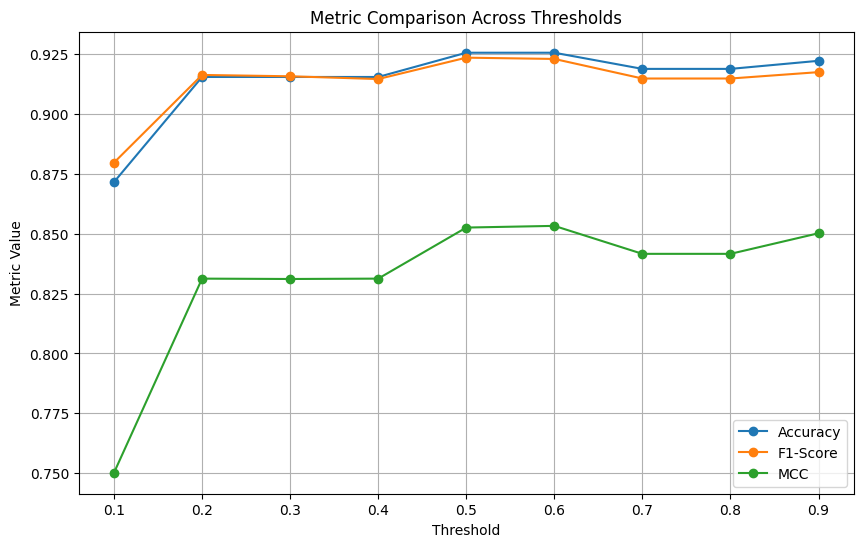

In [16]:


# Function to compute metrics for different thresholds
def evaluate_thresholds(probs, true_labels, thresholds):
    results = []
    for threshold in thresholds:
        preds = (probs >= threshold).astype(int)
        acc = accuracy_score(true_labels, preds)
        f1 = f1_score(true_labels, preds)
        mcc = matthews_corrcoef(true_labels, preds)
        results.append((threshold, acc, f1, mcc))
    return results

# Define thresholds
thresholds = np.linspace(0.1, 0.9, 9)

# Evaluate metrics at different thresholds
results = evaluate_thresholds(y_proba, y_test, thresholds)

# Display results
print("\nThreshold | Accuracy | F1-Score | MCC")
for t, acc, f1, mcc in results:
    print(f"{t:.2f}       | {acc:.4f}   | {f1:.4f}   | {mcc:.4f}")

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'F1', 'MCC'])

# Plot metrics
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['Threshold'], results_df['F1'], label='F1-Score', marker='o')
plt.plot(results_df['Threshold'], results_df['MCC'], label='MCC', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Metric Comparison Across Thresholds')
plt.legend()
plt.grid()
plt.show()


Confusion Matrix:
[[141   7]
 [ 15 133]]


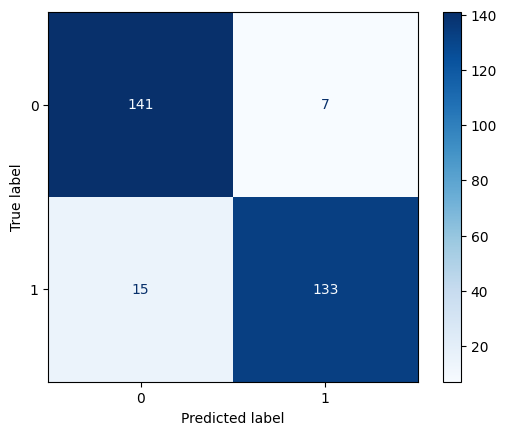

In [17]:

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
